<h1>Практическая работа: "Бинарная логистическая регрессия"</h1>

__Задача бинарной классификации__

___Некая фирма провела анализ зависимости расхода денежных средств на рекламу и эффекта от нее. Если эффект присутствовал, 
то в датасете ставилась 1, в противном случае - 0. Результаты были представоены в виде двух DataFrame х и y.<br>
Произыести бинарную классификацию с использованием логистической регрессии.___  

In [1]:
#Загрузим необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#Исходные данные: x - расходы на рекламу, Y - объемы продаж
x = pd.DataFrame(np.array([39, 36, 60, 21, 27, 12, 51, 57, 54, 42, 18, 9, 48, 66, 6, 30, 24, 33, 15, 21, 100, 200]))
Y = pd.DataFrame(np.array([1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1]))
#display(x, Y)

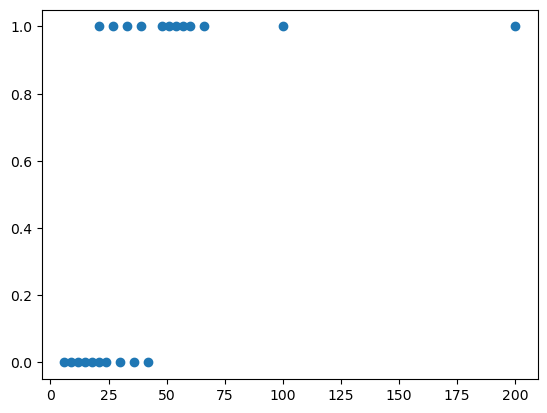

In [4]:
plt.scatter(x,Y)

_Попробуем разделить эти точки прямой линией, отделяющей один класс от другого. 
Модель начинает плохо работать в случае добавления новых точек на больших значениях x:_

In [5]:
a1 = ((x-x.mean())*(Y-Y.mean())).mean()/((x-x.mean())**2).mean()
a0 = Y.mean() - a1*x.mean()
print("Y = ", a0, " + ", a1, " * x")
x_space = np.linspace(6,70,20)
Y_pred = a0.item() + a1.item()*x_space

Y =  0    0.266493
dtype: float64  +  0    0.006333
dtype: float64  * x


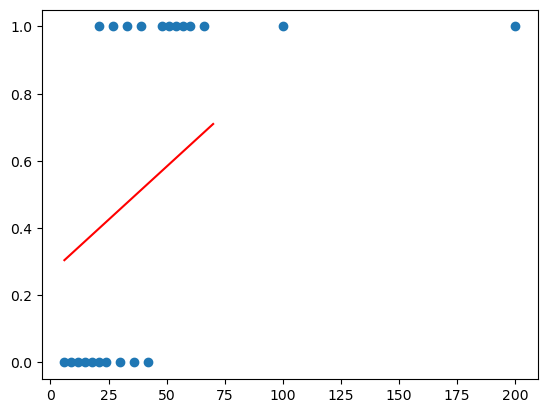

In [6]:
plt.plot(x_space, Y_pred, 'r')
plt.scatter(x, Y)

<h2>Функция логистической регрессии</h2>

__Сигмоида__

Возможное решение упомянутых выше сложностей — пропустить значение линейной регрессии через сигмоиду (sigmoid function), 
которая при любом значении x не выйдет из необходимого нам диапазона от 0 до 1. <br>
<h3>$g(x) = \frac{1}{1+ e^{-x}}$</h3>

 <img src='images/ris1.png' width=320, heigth=240>

<h3>Logistic loss или функция кросс-энтропии</h3>

В модели логистической регрессии мы не можем использовать MSE. Дело в том, 
что если мы поместим результат сигмоиды (представляющей собою нелинейную функцию) в MSE, 
то на выходе получим невыпуклую функцию (non-convex), глобальный минимум которой довольно сложно найти.
 <img src='images/ris2.png' width=520, heigth=240>
    Вместо MSE мы будем использовать функцию логистической ошибки, которую еще называют функцией бинарной кросс-энтропии (log loss, binary cross-entropy loss).

__График и формула функции логистической ошибки__<br>
 <img src='images/ris3.png' width=420, heigth=240>

$J(\theta)=-\frac{1}{n} \sum{y*log(h_{\theta}(x))+(1-y)*log(1-h_{\theta}(x))}$

<h3>Оценка качества модели</h3>

__Матрицa ошибок (confusion matrix)__<br>
 <img src='images/ris4.png' width=420, heigth=240><br>
Доля правильно предсказанных значений называется accuracy. Чтобы ее посчитать, мы берем те значения,
    которые предсказаны верно (TP + TN) и делим на общее количество прогнозов.<br>
    <h3>$accuracy=\frac{TP+TN}{TP+TN+FP+FN}$</h3>

<h2>Конкретизация задачи:</h2>

Реализовать класс модели логистической регрессии с использованием:

а) максимизации логарифмического правдоподобия методом градиентного подъема

б) минимизации функции потерь (кросс-энтропии) методом градиентного спуска

Сравнить результаты (время исполнения и достигнутые значения accuracy и f1) в случаях а и б при одном и том же числе шагов и скорости обучения.

In [7]:
#Реализуем цикл градиентного спуска
class LogisticRegressionGD(object):
    def __init__(self):
        self.a = np.zeros(2).reshape(1, 2)
        
    def sigmoid(self, x):
        return 1/(1 + np.exp(-x @ self.a))
    
    def predict(self, x):
        return self.sigmoid(x)
    
    def coefs(self):
        return self.a
      
    def LogLikelihood(self, x, Y):
        return (Y * np.log(self.predict(x)) + (1 - Y) * np.log(1 - self.predict(x))).sum()

    def CrossEntropy(self, x, Y):
        return (-Y * np.log(self.predict(x)) - (1 - Y) * np.log(1 - self.predict(x))).sum()
    
    def accuracy(self, x, Y):
        return ((self.predict(x) > 0.5)==Y).mean() 

    def fit(self, x, Y, alpha = 0.01, epsylon = 0.01, max_steps = 10000, Rtype = "LL"):
        self.a = np.zeros (x.shape[1]).reshape(x.shape[1],1)
        steps, errors = [], []
        step = 0
        for _ in range(max_steps):
            if Rtype == "LL":
                new_error = self.LogLikelihood(x, Y)
                dT_a = x.T @(Y - self.predict(x)) / x.shape[0]
                self.a += alpha*dT_a
            elif Rtype == "CE":
                new_error = self.CrossEntropy(x, Y)
                #display(new_error)
                dT_a = -x.T @(Y - self.predict(x)) / x.shape[0]
                self.a -= alpha*dT_a
            step += 1
            steps.append(step)
            errors.append(new_error)
            #if new_error < epsylon:
            #    break
        return steps, errors

In [8]:
x_ = x.copy()

import time

intercept = np.ones((x.shape[0], 1))
x_ = pd.DataFrame(np.concatenate((intercept, x), axis = 1))

In [117]:
start_time_CE = time.time()
regr_CE = LogisticRegressionGD()
steps_CE, errors_CE =  regr_CE.fit(x_, Y, alpha = 0.01, epsylon = 0.01, max_steps = 10000, Rtype = "CE") 

display(f"Время обучения: {time.time() - start_time_CE} сек.")

start_time_LL = time.time()
regr_LL = LogisticRegressionGD()
steps_LL, errors_LL =  regr_LL.fit(x_, Y, alpha = 0.01, epsylon = 0.01, max_steps = 10000, Rtype = "LL") 

display(f"Время обучения: {time.time() - start_time_LL} сек.")

'Время обучения: 51.10913443565369 сек.'

'Время обучения: 54.79919672012329 сек.'

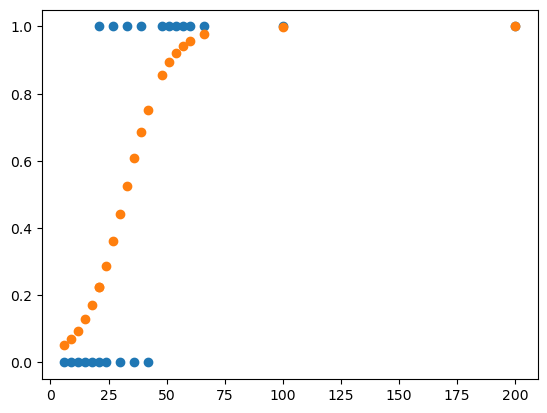

In [118]:
Y_Pred = regr_CE.predict(x_)
plt.scatter(x, Y)
plt.scatter(x, Y_Pred)

In [126]:
display(regr_CE.coefs())
#display(x_)

,0
0,-3.598810
1,0.112152


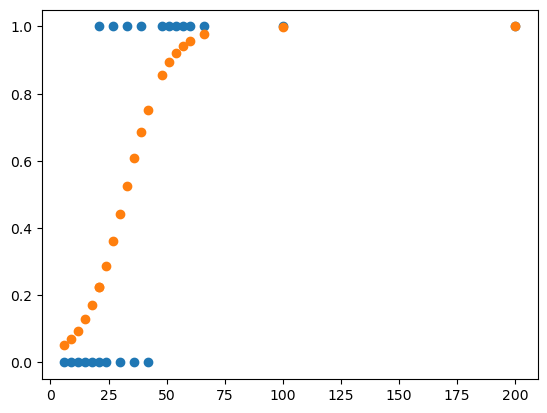

In [120]:
Y_Pred = regr_LL.predict(x_)
plt.scatter(x, Y)
plt.scatter(x, Y_Pred)

In [125]:
display(regr_LL.coefs())
#display(x_)

,0
0,-3.598810
1,0.112152


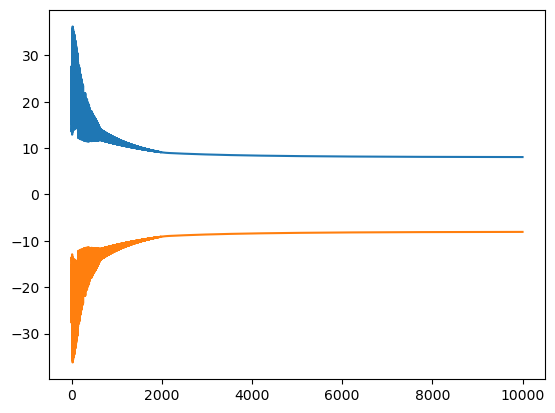

In [122]:
plt.plot(steps_CE, errors_CE)
plt.plot(steps_LL, errors_LL)

In [123]:
print(regr_CE.accuracy(x_, Y))
print(regr_LL.accuracy(x_, Y))

0    0.818182
dtype: float64
0    0.818182
dtype: float64


Реализовать расчеты способами а и б для набора данных из файла insclass_train.csv/
Для 151 406 договоров страхования транспортных средств известны значения ряда признаков, в том числе пол, возраст, стаж вождения и коэффициент бонус-малус водителя, тип, марка, модель, год выпуска, страна – производитель, мощность и объем двигателя, а также признак target, равный 1, если заключение договора с клиентом является рисковым, и 0 в противном случае (файл insclass_train.csv).

Требуется построить модель, предсказывающую значение признака target для 22 624 договоров из тестового набора данных (файл insclass_test.csv).

В обучающем наборе данных для каждого договора известны следующие поля:

variable_1 - агрегированный коэффициент бонус-малус (повышающий или понижающий стоимость полиса в зависимости от аварийности в предыдущие периоды);
variable_2 - индикатор расторжения договора по инициативе страхователя (клиента);
variable_3 - индикатор расторжения договора по инициативе страховщика (страховой компании);
variable_4 - идентификатор года выпуска транспортного средства;
variable_5 - идентификатор страны - производителя транспортного средства;
variable_6 - мощность двигателя в лошадиных силах;
variable_7 - объем двигателя в куб. см;
variable_8 - идентификатор стороны расположения руля (левый или правый);
variable_9 - пробег транспортного средства, покрываемый гарантией производителя;
variable_10 - индикатор действия гарантии на транспортное средство;
variable_11 - "мультидрайв" - индикатор допуска к управлению транспортным средством более одного водителя;
variable_12 - возраст транспортного средства (в мес.);
variable_13 - возраст водителя с максимальным стажем;
variable_14 - коэффициент возраст-стаж;
variable_15 - коэффициент краткосрочности;
variable_16 - коэффициент мощности;
variable_17 - коэффициент "мультидрайв";
variable_18 - территориальный коэффициент;
variable_19 - коэффициент "КНДР";
variable_20 - идентификатор канала продаж;
variable_21 - марка транспортного средства;
variable_22 - модель транспортного средства;
variable_23 - индикатор отечественных транспортных средств;
variable_24 - пол водителя с максимальным коэффициентом "возраст-стаж";
variable_25 - индикатор пролонгации;
variable_26 - индикатор совпадения собственника транспортного средства и водителя;
variable_27 - стаж водителя с максимальным коэффициентом "возраст-стаж";
variable_28 - тип транспортного средства;
target - класс риска, равный 1, если заключение договора с клиентом является рисковым, и 0 в противном случае.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# 1. Загрузка данных
df = pd.read_csv("insclass_train.csv")

# 2. Удаление почти пустого столбца
df = df.drop(columns=['variable_15'])

# 3. Разделение признаков и целевой переменной
X = df.drop(columns='target')
y = df['target']

# 4. Разделение признаков по типу
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# 5. Построение пайплайнов
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# 6. Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Построение модели с логистической регрессией (способ б)
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='lbfgs', max_iter=1000))
])

# 8. Обучение и предсказание
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# 9. Метрики
print("Матрица путаницы:")
print(confusion_matrix(y_test, y_pred))

print("\nОтчёт классификации:")
print(classification_report(y_test, y_pred))


Матрица путаницы:
[[27178   171]
 [ 2682   251]]

Отчёт классификации:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     27349
           1       0.59      0.09      0.15      2933

    accuracy                           0.91     30282
   macro avg       0.75      0.54      0.55     30282
weighted avg       0.88      0.91      0.87     30282



c:\Users\boldi\Desktop\Something\Unik\S2\Machine_learning\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Метод (а) – логарифмическое правдоподобие:
Accuracy: 0.9175112093851729
F1-score: 0.0

Метод (б) – кросс-энтропия:
Accuracy: 0.9175112093851729
F1-score: 0.0


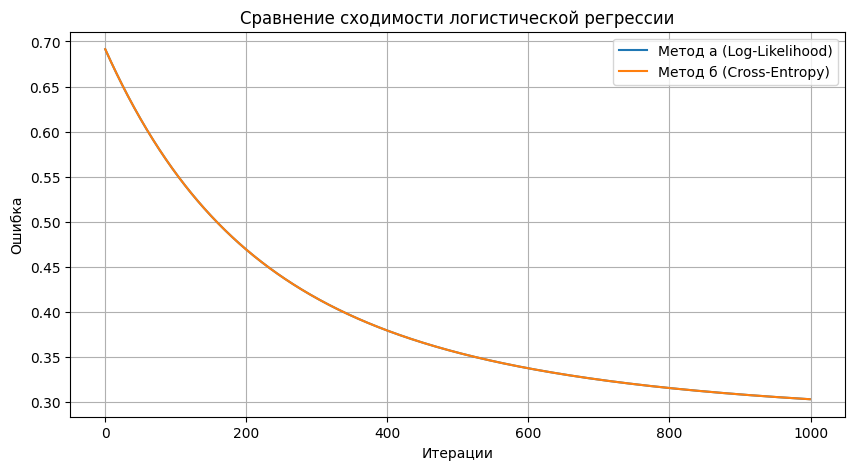

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# 1. Загрузка и подготовка данных
df = pd.read_csv("insclass_train.csv")
columns_used = [
    'variable_4', 'variable_6', 'variable_12', 'variable_13', 'variable_14',
    'variable_16', 'variable_17', 'variable_18', 'variable_19', 'variable_27', 'target'
]
data = df[columns_used].dropna()

X_raw = data.drop(columns='target').values
X_norm = (X_raw - X_raw.mean(axis=0)) / X_raw.std(axis=0)
X = np.hstack([np.ones((X_norm.shape[0], 1)), X_norm])
y = data['target'].values.reshape(-1, 1)

# 2. Сигмоида
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# 3. Функция лог. правдоподобия и кросс-энтропии
def log_likelihood(X, y, theta):
    h = sigmoid(X @ theta)
    return np.mean(y * np.log(h + 1e-9) + (1 - y) * np.log(1 - h + 1e-9))

def cross_entropy(X, y, theta):
    h = sigmoid(X @ theta)
    return -np.mean(y * np.log(h + 1e-9) + (1 - y) * np.log(1 - h + 1e-9))

# 4. Метод а – градиентный подъём (логарифмическое правдоподобие)
def logistic_LL(X, y, alpha=0.01, iterations=1000):
    theta = np.zeros((X.shape[1], 1))
    losses = []
    for _ in range(iterations):
        h = sigmoid(X @ theta)
        gradient = X.T @ (y - h) / X.shape[0]
        theta += alpha * gradient
        losses.append(-log_likelihood(X, y, theta))  # Минус для отображения как "ошибки"
    return theta, losses

# 5. Метод б – градиентный спуск (кросс-энтропия)
def logistic_CE(X, y, alpha=0.01, iterations=1000):
    theta = np.zeros((X.shape[1], 1))
    losses = []
    for _ in range(iterations):
        h = sigmoid(X @ theta)
        gradient = -X.T @ (y - h) / X.shape[0]
        theta -= alpha * gradient
        losses.append(cross_entropy(X, y, theta))
    return theta, losses

# 6. Предсказания
def predict(X, theta, threshold=0.5):
    return (sigmoid(X @ theta) >= threshold).astype(int)

# 7. Обучение
theta_LL, loss_LL = logistic_LL(X, y)
theta_CE, loss_CE = logistic_CE(X, y)

# 8. Предсказания
y_pred_LL = predict(X, theta_LL)
y_pred_CE = predict(X, theta_CE)

# 9. Метрики
print("Метод (а) – логарифмическое правдоподобие:")
print("Accuracy:", accuracy_score(y, y_pred_LL))
print("F1-score:", f1_score(y, y_pred_LL))

print("\nМетод (б) – кросс-энтропия:")
print("Accuracy:", accuracy_score(y, y_pred_CE))
print("F1-score:", f1_score(y, y_pred_CE))

# 10. График функции ошибки
plt.figure(figsize=(10, 5))
plt.plot(loss_LL, label='Метод а (Log-Likelihood)')
plt.plot(loss_CE, label='Метод б (Cross-Entropy)')
plt.xlabel("Итерации")
plt.ylabel("Ошибка")
plt.title("Сравнение сходимости логистической регрессии")
plt.legend()
plt.grid(True)
plt.show()
